ECE 447: Simple Control of a Pendulum
===

Prof. Eric Klavins

&copy; 2019, University of Washington

In [3]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

Recall the pendulum model

$$
\dot{\left (
\begin{array}{c} 
\theta \\ 
\omega
\end{array} \right )} = 
\left (
\begin{array}{c} 
\omega \\ 
\sin\theta-\omega + u
\end{array} \right )
$$

where $u$ is the torque applied to the pendulum.
Suppose the output is the position $\theta$:

$$
y = \theta
$$

We can linearize this system as follows:

In [4]:
var("theta omega u y")
f = Matrix([omega, sin(theta) + - omega + u])
g = Matrix([theta])
pfpx = f.jacobian(Matrix([theta,omega]))
pfpu = f.jacobian(Matrix([u]))
pgpx = g.jacobian(Matrix([theta,omega]))
pgpu = g.jacobian(Matrix([u]))
A = pfpx.subs(theta,0).subs(omega,0).subs(u,0)
B = pfpu.subs(theta,0).subs(omega,0).subs(u,0)
C = pgpx.subs(theta,0).subs(omega,0).subs(u,0)
D = pgpu.subs(theta,0).subs(omega,0).subs(u,0)
A,B,C,D

⎛⎡0  1 ⎤, ⎡0⎤, [1  0], [0]⎞
⎜⎢     ⎥  ⎢ ⎥             ⎟
⎝⎣1  -1⎦  ⎣1⎦             ⎠

So our linear model is 

$$
\dot \x = \begin{pmatrix}
0 & 1 \\
1 & -1
\end{pmatrix} \x + \begin{pmatrix}
0 \\
1
\end{pmatrix} u
$$

$$
y = ( 0 \; 1 ) \x
$$

A somewhat simple way to control the pendulum to track a *reference input* r is to just wqrap a feedback loop around the system with a gain $K$.

<img src="https://raw.githubusercontent.com/klavins/ECE447/master/images/feedback-loop-pendulum.png" width=70%>

In this case, we get a new linear system with input $r$ and output $y$. Here, $K$ is a *tunable* design parameter.

We can find the equations for the new system by noting that

$$
u = K(r-y)
$$

then

\begin{array}
\dot \x & = A \x + B K (r-y) \\
        & = A \x + B K r - B K C \x \\
        & = ( A - B K C ) \x + B K r
\end{array}

so our new system has

$$
\dot x = \tilde{A} \x + \tilde{B} r
$$

with 

$$
\tilde{A} = A - B K C 
$$

and

$$
\tilde{B} = B K
$$

Since we still have $y = \theta$, we still have $y = C \x$ as before.

Using `sympy` we can compute these matrices:

In [7]:
var("K")
Anew = A - K*B*C
Bnew = K*B
Anew,Bnew

⎛⎡  0     1 ⎤, ⎡0⎤⎞
⎜⎢          ⎥  ⎢ ⎥⎟
⎝⎣-K + 1  -1⎦  ⎣K⎦⎠

We can can find the eigenvalues of $\tilde{A}$:

In [10]:
lam1,lam2=Anew.eigenvals()
lam1,lam2

⎛    __________        __________    ⎞
⎜  ╲╱ -4⋅K + 5    1  ╲╱ -4⋅K + 5    1⎟
⎜- ──────────── - ─, ──────────── - ─⎟
⎝       2         2       2         2⎠

And plot them as a function of $K$:

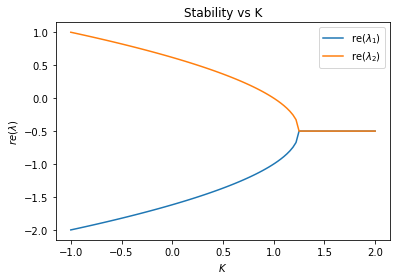

In [19]:
kvals = np.linspace(-1,2,101)
f1=lambdify(K,re(lam1), modules=['numpy'])
f2=lambdify(K,re(lam2), modules=['numpy'])
plt.plot(kvals,f1(kvals), label="$\mathrm{re}(\lambda_1)$")
plt.plot(kvals,f2(kvals), label="$\mathrm{re}(\lambda_2)$")
plt.xlabel("$K$")
plt.ylabel("$re(\lambda)$")
plt.title("Stability vs K")
plt.legend();

In [15]:
lam1.subs(K,1),lam2.subs(K,1)

(-1, 0)

In [82]:
lam1.subs(K,1.1),lam2.subs(K,1.1)

(-0.887298334620742, -0.112701665379258)

In [83]:
lam1.subs(K,5/4),lam2.subs(K,5/4)

(-1/2, -1/2)

In [98]:
var("t tau r")
x0=Matrix([0,0])
xnat = exp(Anew.subs(K,k)*t)*x0
xforced = integrate(exp(Anew.subs(K,k)*(t-tau))*Bnew*r,(tau,0,t))
x = xnat + xforced
y = C*x + D*r
y

⎡                                 -0.5⋅t⎤
⎣4.0⋅K⋅r - (2.0⋅K⋅r⋅t + 4.0⋅K⋅r)⋅ℯ      ⎦

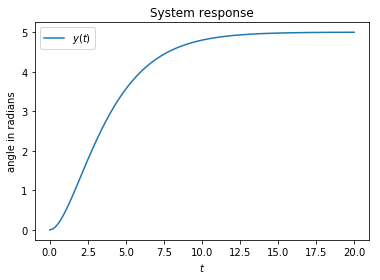

In [99]:
tvals = np.linspace(0,20,100)
f = lambdify(t,y[0].subs(r,1).subs(K,k), modules=['numpy'])
plt.figure()   
plt.plot(tvals, f(tvals),label="$y(t)$")
plt.xlabel('$t$')
plt.ylabel('angle in radians')
plt.title("System response")
plt.legend();

Note that an annoying thing that happens is that $r$ gets scaled by $B$, which has a $K$ in it. So typically one scales $r$ with to make it match the desired output size. Thus, we get something more like:

In [103]:
limit(xforced[0],t,oo),limit(xforced[1],t,oo)

(4.0⋅K⋅r, 0)

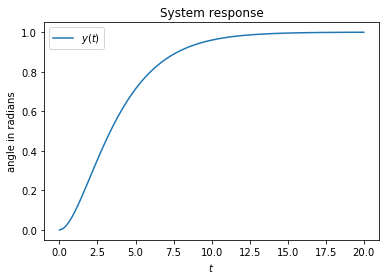

In [102]:
tvals = np.linspace(0,20,100)
f = lambdify(t,y[0].subs(r,1/(4*K)).subs(K,5/4), modules=['numpy'])
plt.figure()   
plt.plot(tvals, f(tvals),label="$y(t)$")
plt.xlabel('$t$')
plt.ylabel('angle in radians')
plt.title("System response")
plt.legend();